# Setup libraries , sparksessipm and other imporant configuration

In [257]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import col, instr, substring, length, regexp_extract,regexp_replace, desc, row_number, to_date
from datetime import date 
import os
spark = SparkSession.builder \
    .appName("real_estate_pre_application_activity") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
spark.sparkContext.setLogLevel("FATAL")


# Set Variable

I setup a reusable variable for target and source for more cleaner script.

In [ ]:
sourcepath = "/Users/jetbtabing/Documents/myGitRepo/Spark/upwork/client1_realestate/source/"
targetpath = "/Users/jetbtabing/Documents/myGitRepo/Spark/upwork/client1_realestate/target/"

# Read source files
The script below is very straight forward it only reads the CSV file and load it to a dataframe(s)

In [ ]:
df_keys = spark.read.csv(sourcepath + 'KEYS.csv', header=True, inferSchema=True)
df_redfin_median_sales_price = spark.read.csv(sourcepath + 'REDFIN_MEDIAN_SALE_PRICE.csv', header=True, inferSchema=True)
df_census_population_state = spark.read.csv(sourcepath + 'CENSUS_POPULATION_STATE.tsv', sep="\t", header=True, inferSchema=True)
df_cencus_mhi_state = spark.read.csv(sourcepath + 'CENSUS_MHI_STATE.csv', header=True, inferSchema=True)

# Functions

## Defined function to extract column details from dataframe(s)

This  script below defines a function called get_colum_to_transpose, which is  used to prepare a DataFrame for transposing columns into rows — this will be use to transpose the record for easily use.

In [269]:
def get_colum_to_transpose(dataframe1):
    df = dataframe1
    columns_to_transpose = [col for col in df.columns if col not in ['Label (Grouping)']]
    stack_expr = ", ".join([f"'{c}', `{c}`" for c in columns_to_transpose]) 
    return columns_to_transpose, stack_expr

# Inital Data Cleansing & Tranformation

For the initial data cleansing and transformation I carefully studied the formulas in Google Sheets and tried to replicate the logic each formula performs here.

## Get Keys

No major transformation on this dataframe just filtering the region_type = 'state' to pull the 52 expected record from the datasource **Keys**

In [261]:
#Setup dataframe for keys

df_base_key = df_keys.filter("region_type = 'state'")


## Census Population State

This PySpark script performs a transpose and cleansing of census population data in order to make it easier to join with key data



In [ ]:

df_filtered_census = df_census_population_state.filter("`Label (Grouping)` = '    Total population'").distinct()

columns_to_transpose = get_colum_to_transpose(df_filtered_census)[0]
stack_expr = get_colum_to_transpose(df_filtered_census)[1]

df_cencus_transposed = df_filtered_census.selectExpr(
                                            "`Label (Grouping)` as Label",  # Keep key columns
                                            f"stack({len(columns_to_transpose)}, {stack_expr}) as (Metric, Value)"
                                             ).filter("Metric LIKE '%Estimate%%'")

df_cleansed_cencus_population =  df_cencus_transposed.withColumn("State", regexp_extract("Metric", r"(.*)!!", 1))\
                              .withColumn("Type", regexp_extract("Metric", r"!!(.*)", 1)).select("State", "Type", "Value")\
                              .withColumn("int_Value", regexp_replace("Value",",","").cast("int"))\

#df_cleansed_cencus_population.show()


## Redfin Median Sales

This PySpark script performs a transpose and cleansing of  Redfin Median Sales data in order to make it easier to join with key data


In [263]:


#get the first row of the dataframe to use as column names
first_row = df_redfin_median_sales_price.first()
new_column_names = [str(x) for x in first_row]
df_no_header = df_redfin_median_sales_price.rdd.zipWithIndex().filter(lambda x: x[1] > 0).keys().toDF()
df_transformed_redfin = df_no_header.toDF(*new_column_names)

#collect column for transpose
columns_to_transpose = get_colum_to_transpose(df_transformed_redfin)[0]
stack_expr = get_colum_to_transpose(df_transformed_redfin)[1]


df_transposed_redfin = df_transformed_redfin.selectExpr(
                                            "Region",  # Keep key columns
                                            f"stack({len(columns_to_transpose)}, {stack_expr}) as (MonthEndPeriod, Value)"
                                             ).filter("MonthEndPeriod <> 'Region'")


window_spec = Window.partitionBy("State").orderBy(desc("MonthEndPeriod_Date"))


df_cleansed_redfin_median = df_transposed_redfin\
                                .withColumn("Value", regexp_replace("Value", "[K]" ,""))\
                                .withColumn("int_Value", (regexp_replace("Value","[$K]","").cast("int")*1000))\
                                .withColumn("MonthEndPeriod_Date", to_date("MonthEndPeriod", "MMMM yyyy"))\
                                .select(col("Region").alias("State")\
                                            ,col("MonthEndPeriod")\
                                             ,col("MonthEndPeriod_Date")\
                                             ,col("Value").alias("Value")\
                                              ,col("int_Value").alias("int_Value"))\
                                             .withColumn("rank", row_number().over(window_spec))\
                                                 .filter(col("rank") == 1).drop("rank")
#df_cleansed_redfin_median.show()

## Cencus MHI State

This PySpark script performs a transpose and cleansing of Cencus MHI State data in order to make it easier to join with key data

In [264]:
df_filtered_census_mhi = df_cencus_mhi_state.filter("`Label (Grouping)` = '    Households'").distinct()

columns_to_transpose = get_colum_to_transpose(df_filtered_census_mhi)[0]
stack_expr = get_colum_to_transpose(df_filtered_census_mhi)[1]

# Transpose 
df_filtered_census_mhi = df_filtered_census_mhi.selectExpr(
                                            "`Label (Grouping)` as Label",  # Keep key columns
                                            f"stack({len(columns_to_transpose)}, {stack_expr}) as (Metric, Value)"
                                            ).filter("Metric LIKE '%Median income (dollars)!!Estimate%%'")

df_cleansed_census_mhi =  df_filtered_census_mhi.withColumn("State", regexp_extract("Metric", r"(.*)!!", 1))\
                                .withColumn("State", regexp_extract("State", r"(.*)!!", 1))\
                                .withColumn("int_Value", regexp_replace("Value",",","").cast("int"))\
                                .select("State", "Value", "int_Value")\

#df_cleansed_census_mhi.show()

# Build the report 
for this excercise I will use spark sql to show how easily this report can be built

In [265]:
df_base_key.createOrReplaceTempView("keys")
df_cleansed_redfin_median.createOrReplaceTempView("redfin_median_sales_price")
df_cleansed_cencus_population.createOrReplaceTempView("census_population_state")
df_cleansed_census_mhi.createOrReplaceTempView("census_mhi_state")

## Spark SQL creating final output

This Spark SQL query joins key regional data with census and real estate metrics, calculates rankings and human-readable rank labels for population, income, home prices, and affordability, then generates descriptive blurbs for each region summarizing how it compares nationally across those metrics.

In [266]:
df_output = spark.sql("""
                WITH base AS (
                        SELECT
                        k.key_row
                        ,k.alternative_name
                        ,cps.Value as census_population
                        ,RANK() OVER (ORDER BY cps.int_Value DESC) AS population_rank
                        ,cms.Value as median_household_income
                        ,RANK() OVER (ORDER BY cms.int_Value DESC) AS median_household_income_rank
                        ,concat(rmsp.Value,',000')  as median_sale_price
                        ,RANK() OVER (ORDER BY rmsp.int_Value DESC) AS median_sale_price_rank
                        ,ROUND((rmsp.int_Value / cms.int_Value),1) as house_affordability_ratio
                        ,RANK() OVER (ORDER BY ROUND((rmsp.int_Value / cms.int_Value),1) DESC) AS house_affordability_ratio_rank
                        ,rmsp.MonthEndPeriod
                        FROM keys k
                        LEFT JOIN census_population_state cps 
                                ON k.census_msa = cps.State
                        LEFT JOIN census_mhi_state cms
                                ON k.census_msa = cms.State 
                        LEFT JOIN redfin_median_sales_price rmsp
                                ON k.redfin_region = rmsp.State
                ),v_ranked AS (
                   SELECT
                        base.*
                        ,CASE
                                WHEN base.population_rank % 100 BETWEEN 11 AND 13 THEN
                                CAST(base.population_rank AS STRING) || 'th'
                                WHEN base.population_rank % 10 = 1 THEN
                                CAST(base.population_rank AS STRING) || 'st'
                                WHEN base.population_rank % 10 = 2 THEN
                                CAST(base.population_rank AS STRING) || 'nd'
                                WHEN base.population_rank % 10 = 3 THEN
                                CAST(base.population_rank AS STRING) || 'rd'
                                ELSE
                                CAST(base.population_rank AS STRING) || 'th'
                                END AS population_rank_label
                        ,CASE
                                WHEN base.median_household_income_rank % 100 BETWEEN 11 AND 13 THEN
                                CAST(base.median_household_income_rank AS STRING) || 'th'
                                WHEN base.median_household_income_rank % 10 = 1 THEN
                                CAST(base.median_household_income_rank AS STRING) || 'st'
                                WHEN base.median_household_income_rank % 10 = 2 THEN
                                CAST(base.median_household_income_rank AS STRING) || 'nd'
                                WHEN base.median_household_income_rank % 10 = 3 THEN
                                CAST(base.median_household_income_rank AS STRING) || 'rd'
                                ELSE
                                CAST(base.median_household_income_rank AS STRING) || 'th'
                                END AS median_household_income_rank_label
                        ,CASE
                                WHEN base.median_sale_price_rank % 100 BETWEEN 11 AND 13 THEN
                                CAST(base.median_sale_price_rank AS STRING) || 'th'
                                WHEN base.median_sale_price_rank % 10 = 1 THEN
                                CAST(base.median_sale_price_rank AS STRING) || 'st'
                                WHEN base.median_sale_price_rank % 10 = 2 THEN
                                CAST(base.median_sale_price_rank AS STRING) || 'nd'
                                WHEN base.median_sale_price_rank % 10 = 3 THEN
                                CAST(base.median_sale_price_rank AS STRING) || 'rd'
                                ELSE
                                CAST(base.median_sale_price_rank AS STRING) || 'th'
                                END AS median_sale_price_rank_label
                        ,CASE
                                WHEN base.house_affordability_ratio_rank % 100 BETWEEN 11 AND 13 THEN
                                CAST(base.house_affordability_ratio_rank AS STRING) || 'th'
                                WHEN base.house_affordability_ratio_rank % 10 = 1 THEN
                                CAST(base.house_affordability_ratio_rank AS STRING) || 'st'
                                WHEN base.house_affordability_ratio_rank % 10 = 2 THEN
                                CAST(base.house_affordability_ratio_rank AS STRING) || 'nd'
                                WHEN base.house_affordability_ratio_rank % 10 = 3 THEN
                                CAST(base.house_affordability_ratio_rank AS STRING) || 'rd'
                                ELSE
                                CAST(base.house_affordability_ratio_rank AS STRING) || 'th'
                                END AS house_affordability_ratio_label
                FROM base
               )
                SELECT 
                      key_row
                --population
                      ,census_population
                      ,population_rank_label AS population_rank
                      ,CONCAT(alternative_name,' is ', population_rank_label, ' in the nation in population among states, DC, and Puerto Rico.') AS population_blurb

                --median_house_income
                      ,median_household_income
                      ,median_household_income_rank_label AS median_household_income_rank
                      ,CONCAT(alternative_name,' is ', CASE WHEN median_household_income_rank_label ='1st' THEN 'the highest' ELSE median_household_income_rank_label END, ' in the nation in median household income among states, DC, and Puerto Rico.' ) AS median_household_income_blurb
                
                --median_sales 
                      ,median_sale_price
                      ,median_sale_price_rank_label AS median_sale_price_rank
                      ,CONCAT(alternative_name,' has the ', CASE WHEN median_sale_price_rank_label ='1st' THEN 'single' ELSE median_sale_price_rank_label END, ' highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from ',  MonthEndPeriod) AS median_sale_price_blurb

                --house_affordability_ratio
                      ,house_affordability_ratio
                      ,house_affordability_ratio_label AS house_affordability_ratio_rank
                      ,CONCAT(alternative_name,' has a ', CASE WHEN house_affordability_ratio_label ='1st' THEN 'single' ELSE house_affordability_ratio_label END, ' lowest house affordability ratio in the nation among states, DC, and Puerto Rico, according to Redfin data from ', MonthEndPeriod) AS house_affordability_ratio_blurb
                FROM v_ranked
                ORDER BY key_row
         """)
df_output.count()
# df_output.show()

52

## Writing the CSV output

As per the requirements, the output should be in CSV format. I added a dynamic date to the output folder in order to identify when the report is generated. 

In [267]:
df_output.write.csv(targetpath + 'output_analysis_of_state_' + str(date.today()).replace('-','_'), header=True, mode='overwrite')

# **Important Notes*

On the output CSV file you will noticed that the puerto_rico does not have data for columns median_sales. That is because it is not available in the source. If you will compare it tothe sample google spreadsheet you will see a data but that is because the data there for puerto rico is no longer generated by spread sheet formula(already a fixed data).


**Output CSV:**

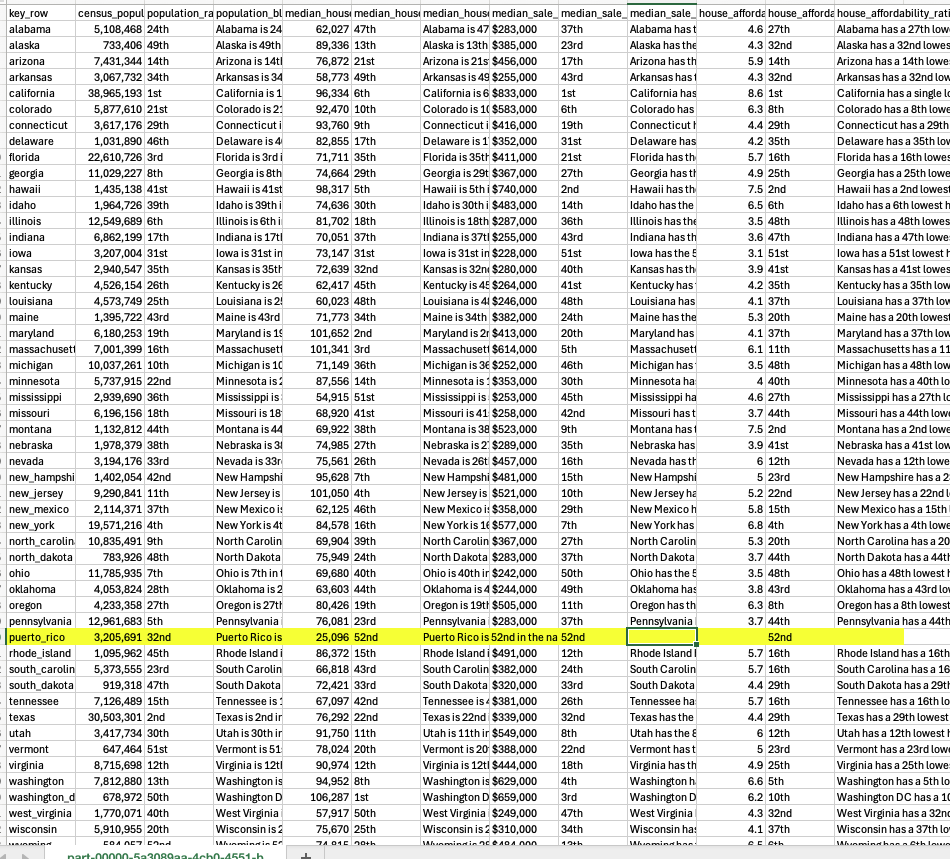

----------

**Google Spreadsheet:**

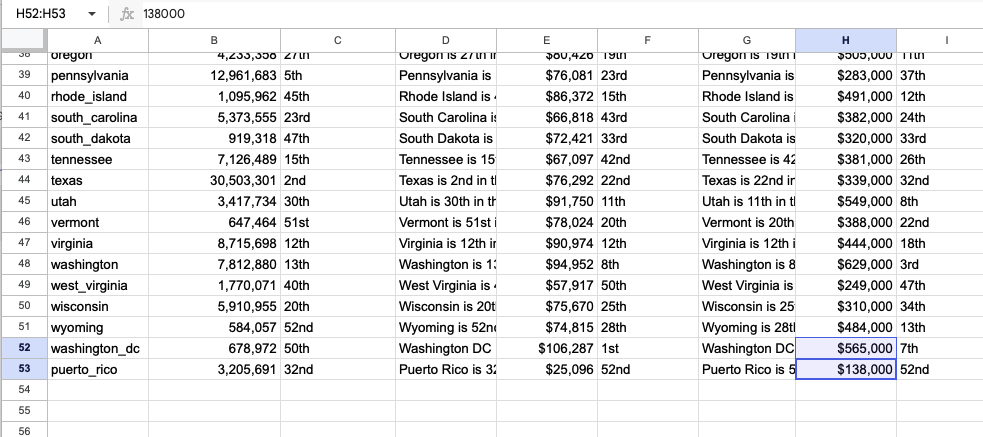

----------

**For the output CSV file please download the file here***

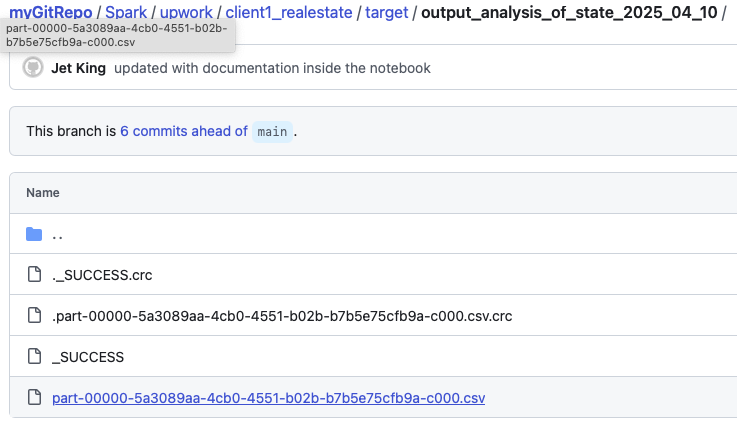